# Create a Fingerstick, Serum Glucose Pairs Dataset derived from eICU-CRD

## defines and imports

In [88]:
!pip install tableone

In [89]:
import matplotlib.pyplot as plt
import pandas as pd
#import tableone
from google.colab import files, drive
from google.colab import auth
auth.authenticate_user()
drive.mount('/content/drive')
print('Authenticated')

%load_ext google.colab.data_table

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Authenticated
The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from google.colab import drive

In [5]:
%config InlineBackend.figure_format = 'retina'

In [6]:
# change this to change the right project
%env GOOGLE_CLOUD_PROJECT = sccm-datathon-2023-participant

env: GOOGLE_CLOUD_PROJECT=sccm-datathon-2023-participant


## eicu baseline

In [90]:
%%bigquery eicu_patients

SELECT *
FROM `physionet-data.eicu_crd_derived.icustay_detail`


Query is running:   0%|          |

Downloading:   0%|          |

In [93]:
pats = eicu_patients.groupby('uniquepid').first()

In [94]:
pats.ethnicity.value_counts(normalize=True)

Caucasian           0.772880
African American    0.105283
Other/Unknown       0.047787
Hispanic            0.037541
Asian               0.016805
                    0.012772
Native American     0.006931
Name: ethnicity, dtype: float64

In [95]:
pats.gender.value_counts(normalize=True)

1    0.540021
0    0.459979
Name: gender, dtype: Float64

## pairs

In [7]:
%%bigquery df_eicu

SELECT DISTINCT
  core_glucose.patientunitstayid
  , core_glucose.labresultoffset AS core_glucose_offset
  , core_glucose.labresult AS core_glucose
  , poc_glucose.labresultoffset AS poc_glucose_offset
  , poc_glucose.labresult AS poc_glucose

FROM `physionet-data.eicu_crd.lab` core_glucose
INNER JOIN `physionet-data.eicu_crd.lab` poc_glucose ON
  poc_glucose.patientunitstayid = core_glucose.patientunitstayid AND
  poc_glucose.labname = 'bedside glucose' AND
  ABS(core_glucose.labresultoffset - poc_glucose.labresultoffset) < 60
WHERE
  core_glucose.labname = 'glucose'
  AND core_glucose.labresult IS NOT NULL
  AND poc_glucose.labresult IS NOT NULL

Query is running:   0%|          |

Downloading:   0%|          |

In [8]:
df_eicu['delta_offset'] = df_eicu['core_glucose_offset'] - df_eicu['poc_glucose_offset']
df_eicu['delta_glucose'] = df_eicu['core_glucose'] - df_eicu['poc_glucose']

In [9]:
display(df_eicu)

,patientunitstayid,core_glucose_offset,core_glucose,poc_glucose_offset,poc_glucose,delta_offset,delta_glucose
0,656658,-300,45.0,-334,34.0,34,11.0
1,724732,9123,43.0,9117,36.0,6,7.0
2,1786193,2486,48.0,2528,40.0,-42,8.0
3,1808587,773,170.0,757,40.0,16,130.0
4,1579198,371,41.0,412,44.0,-41,-3.0
...,...,...,...,...,...,...,...
360024,492705,4430,154.0,4426,167.0,4,-13.0
360025,481443,76,196.0,66,167.0,10,29.0
360026,1026147,-5720,186.0,-5738,167.0,18,19.0
360027,3085392,8945,147.0,8932,167.0,13,-20.0


<Axes: >

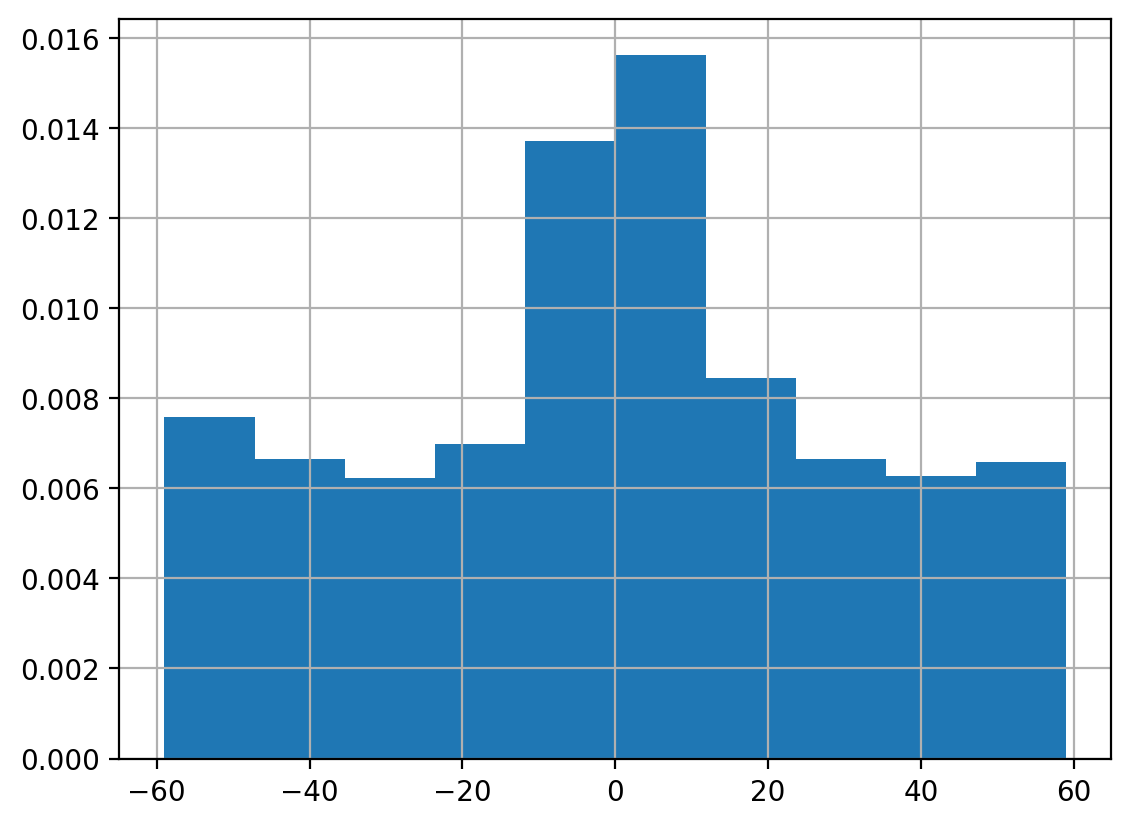

In [10]:
df_eicu['delta_offset'].hist(density=True)

In [11]:
len(df_eicu[df_eicu['delta_glucose'].abs() < 15]) / len(df_eicu)

0.6305547608664858

In [12]:
# df_eicu = df_eicu[(df_eicu['delta_glucose'] <= 200) & (df_eicu['delta_glucose'] >= -200)]

<Axes: >

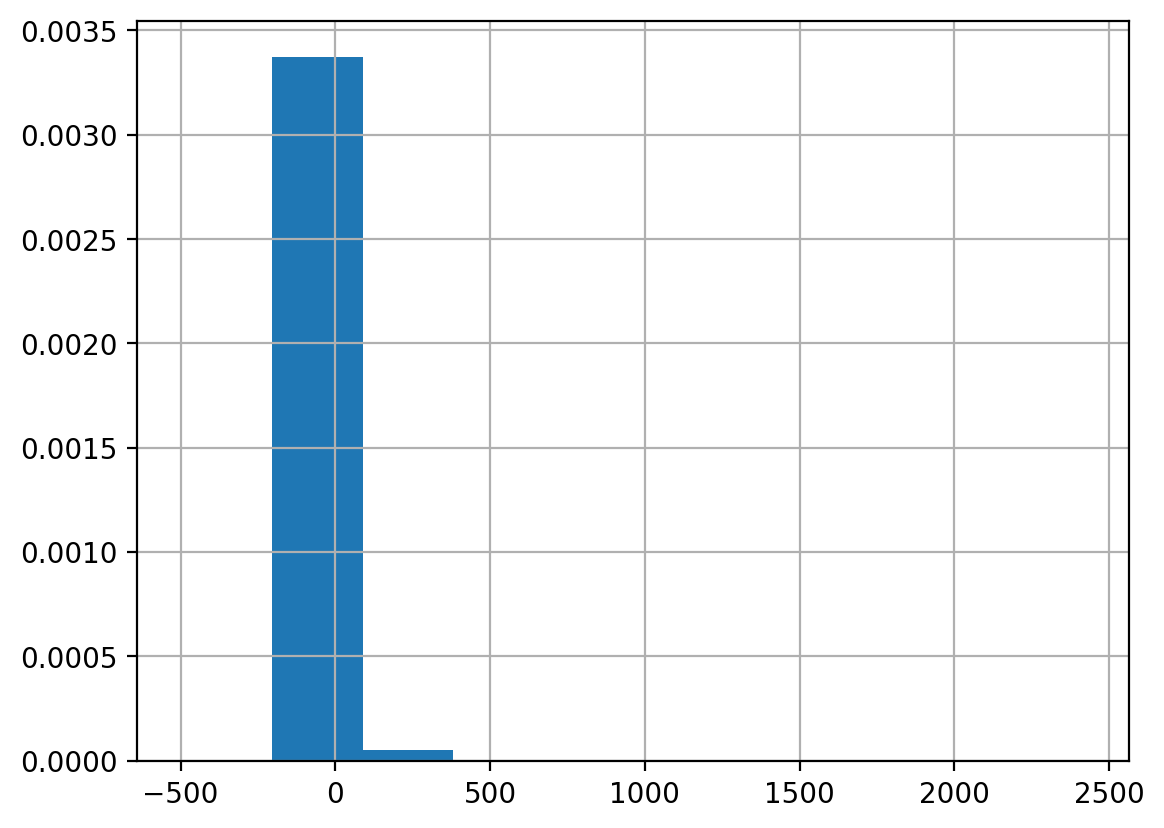

In [13]:
df_eicu['delta_glucose'].hist(density=True)

In [14]:
pairs = df_eicu

In [15]:
len(pairs)

360029

## demographics, illness severity, outcomes

In [16]:
%%bigquery df_icustay

SELECT *
FROM `physionet-data.eicu_crd_derived.icustay_detail`

Query is running:   0%|          |

Downloading:   0%|          |

In [17]:
df_1 = pairs.merge(df_icustay, on="patientunitstayid", how='left')

In [18]:
len(df_1)

360029

In [98]:
pats = df_1.groupby('uniquepid').first()

In [99]:
pats.ethnicity.value_counts(normalize=True)

Caucasian           0.759656
African American    0.112588
Other/Unknown       0.051485
Hispanic            0.042845
Asian               0.015582
                    0.009450
Native American     0.008395
Name: ethnicity, dtype: float64

In [100]:
pats.gender.value_counts(normalize=True)

1    0.553438
0    0.446562
Name: gender, dtype: Float64

In [102]:
df_cut = df_1[df_1['delta_glucose'].abs() < 15]

,patientunitstayid,core_glucose_offset,core_glucose,poc_glucose_offset,poc_glucose,delta_offset,delta_glucose,uniquepid,patienthealthsystemstayid,unitvisitnumber,...,apache_iv,hospitaldischargeyear,age,hosp_mort,gender,ethnicity,admissionheight,admissionweight,dischargeweight,icu_los_hours
0,656658,-300,45.0,-334,34.0,34,11.0,006-179266,524521,1,...,113,2014,79,0,0,Caucasian,162.5,76.00,80.60,144.0
1,724732,9123,43.0,9117,36.0,6,7.0,006-144318,565216,2,...,<NA>,2014,32,0,1,Hispanic,153.0,49.00,49.30,312.0
2,1786193,2486,48.0,2528,40.0,-42,8.0,018-27002,1402676,1,...,40,2015,52,0,1,Caucasian,167.6,80.00,79.80,52.0
4,1579198,371,41.0,412,44.0,-41,-3.0,016-2799,1220596,1,...,104,2015,64,1,0,Caucasian,177.8,90.71,90.70,69.0
5,2752730,-199,60.0,-214,54.0,15,6.0,027-4112,2216655,1,...,78,2015,70,0,0,Caucasian,152.4,75.80,NaN,98.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360020,1335492,14129,158.0,14117,167.0,12,-9.0,013-2261,1016292,1,...,81,2014,63,1,1,Asian,167.6,62.30,29.20,393.0
360021,2369747,1986,166.0,1985,167.0,1,-1.0,022-170955,1878959,1,...,25,2014,20,0,0,Caucasian,160.0,94.30,97.93,59.0
360023,2197106,2422,157.0,2385,167.0,37,-10.0,021-62457,1740345,1,...,55,2014,38,0,0,Caucasian,152.4,54.00,62.60,25.0
360024,492705,4430,154.0,4426,167.0,4,-13.0,005-13213,417299,1,...,93,2015,78,0,0,Other/Unknown,160.0,NaN,NaN,157.0


## comorbidities

In [19]:
%%bigquery charlson
--forked from https://github.com/theonesp/vol_leak_index/blob/master/eicu_vli/analysis/sql/charlson_score.sql

WITH
  t1 AS (
  SELECT
    s.patientunitstayid,
    MAX (CASE
        WHEN ph.pasthistorypath IN ( 'notes/Progress Notes/Past History/Organ Systems/Hematology/Oncology (R)/Cancer/Metastases/other', 'notes/Progress Notes/Past History/Organ Systems/Hematology/Oncology (R)/Cancer/Metastases/brain', 'notes/Progress Notes/Past History/Organ Systems/Hematology/Oncology (R)/Cancer/Metastases/carcinomatosis', 'notes/Progress Notes/Past History/Organ Systems/Hematology/Oncology (R)/Cancer/Metastases/nodes', 'notes/Progress Notes/Past History/Organ Systems/Hematology/Oncology (R)/Cancer/Metastases/lung', 'notes/Progress Notes/Past History/Organ Systems/Hematology/Oncology (R)/Cancer/Metastases/intra-abdominal', 'notes/Progress Notes/Past History/Organ Systems/Hematology/Oncology (R)/Cancer/Metastases/bone', 'notes/Progress Notes/Past History/Organ Systems/Hematology/Oncology (R)/Cancer/Metastases/liver') THEN 6
      ELSE
      0
    END
      ) AS mets6,
    MAX (CASE
        WHEN ph.pasthistorypath = 'notes/Progress Notes/Past History/Organ Systems/Infectious Disease (R)/AIDS/AIDS' THEN 6
      ELSE
      0
    END
      ) AS aids6,
    MAX (CASE
        WHEN ph.pasthistorypath IN ( 'notes/Progress Notes/Past History/Organ Systems/Gastrointestinal (R)/Cirrhosis/UGI bleeding', 'notes/Progress Notes/Past History/Organ Systems/Gastrointestinal (R)/Cirrhosis/varices', 'notes/Progress Notes/Past History/Organ Systems/Gastrointestinal (R)/Cirrhosis/coma', 'notes/Progress Notes/Past History/Organ Systems/Gastrointestinal (R)/Cirrhosis/jaundice', 'notes/Progress Notes/Past History/Organ Systems/Gastrointestinal (R)/Cirrhosis/ascites', 'notes/Progress Notes/Past History/Organ Systems/Gastrointestinal (R)/Cirrhosis/encephalopathy') THEN 3
      ELSE
      0
    END
      ) AS liver3,
    MAX (CASE
        WHEN ph.pasthistorypath IN ( 'notes/Progress Notes/Past History/Organ Systems/Neurologic/Strokes/multiple/multiple', 'notes/Progress Notes/Past History/Organ Systems/Neurologic/Strokes/stroke - remote', 'notes/Progress Notes/Past History/Organ Systems/Neurologic/Strokes/stroke - within 5 years', 'notes/Progress Notes/Past History/Organ Systems/Neurologic/Strokes/stroke - within 2 years', 'notes/Progress Notes/Past History/Organ Systems/Neurologic/Strokes/stroke - date unknown', 'notes/Progress Notes/Past History/Organ Systems/Neurologic/Strokes/stroke - within 6 months') THEN 2
      ELSE
      0
    END
      ) AS stroke2,
    MAX (CASE
        WHEN ph.pasthistorypath IN ( 'notes/Progress Notes/Past History/Organ Systems/Renal  (R)/Renal Insufficiency/renal insufficiency - creatinine 1-2', 'notes/Progress Notes/Past History/Organ Systems/Renal  (R)/Renal Insufficiency/renal insufficiency - creatinine 3-4', 'notes/Progress Notes/Past History/Organ Systems/Renal  (R)/Renal Insufficiency/renal insufficiency - creatinine > 5', 'notes/Progress Notes/Past History/Organ Systems/Renal  (R)/Renal Insufficiency/renal insufficiency - baseline creatinine unknown', 'notes/Progress Notes/Past History/Organ Systems/Renal  (R)/Renal Insufficiency/renal insufficiency - creatinine 4-5', 'notes/Progress Notes/Past History/Organ Systems/Renal  (R)/Renal Insufficiency/renal insufficiency - creatinine 2-3', 'notes/Progress Notes/Past History/Organ Systems/Renal  (R)/Renal Failure/renal failure - peritoneal dialysis', 'notes/Progress Notes/Past History/Organ Systems/Renal  (R)/Renal Failure/renal failure- not currently dialyzed', 'notes/Progress Notes/Past History/Organ Systems/Renal  (R)/Renal Failure/renal failure - hemodialysis') THEN 2
      ELSE
      0
    END
      ) AS renal2,
    MAX (CASE
        WHEN ph.pasthistorypath IN ( 'notes/Progress Notes/Past History/Organ Systems/Endocrine (R)/Insulin Dependent Diabetes/insulin dependent diabetes', 'notes/Progress Notes/Past History/Organ Systems/Endocrine (R)/Non-Insulin Dependent Diabetes/non-medication dependent', 'notes/Progress Notes/Past History/Organ Systems/Endocrine (R)/Non-Insulin Dependent Diabetes/medication dependent') THEN 1
      ELSE
      0
    END
      ) AS dm,
    MAX (CASE
        WHEN ph.pasthistorypath IN ( 'notes/Progress Notes/Past History/Organ Systems/Hematology/Oncology (R)/Cancer Therapy/Chemotherapy/Anthracyclines (adriamycin, daunorubicin)', 'notes/Progress Notes/Past History/Organ Systems/Hematology/Oncology (R)/Cancer/Cancer-Primary Site/bone', 'notes/Progress Notes/Past History/Organ Systems/Hematology/Oncology (R)/Cancer/Cancer-Primary Site/stomach', 'notes/Progress Notes/Past History/Organ Systems/Hematology/Oncology (R)/Cancer/Cancer-Primary Site/bile duct', 'notes/Progress Notes/Past History/Organ Systems/Hematology/Oncology (R)/Cancer/Cancer-Primary Site/kidney', 'notes/Progress Notes/Past History/Organ Systems/Hematology/Oncology (R)/Cancer/Cancer-Primary Site/unknown', 'notes/Progress Notes/Past History/Organ Systems/Hematology/Oncology (R)/Cancer Therapy/Radiation Therapy within past 6 months/primary site', 'notes/Progress Notes/Past History/Organ Systems/Hematology/Oncology (R)/Cancer/Cancer-Primary Site/breast', 'notes/Progress Notes/Past History/Organ Systems/Hematology/Oncology (R)/Cancer/Cancer-Primary Site/uterus', 'notes/Progress Notes/Past History/Organ Systems/Hematology/Oncology (R)/Cancer Therapy/Radiation Therapy within past 6 months/bone', 'notes/Progress Notes/Past History/Organ Systems/Hematology/Oncology (R)/Cancer/Cancer-Primary Site/prostate', 'notes/Progress Notes/Past History/Organ Systems/Hematology/Oncology (R)/Cancer/Cancer-Primary Site/liver', 'notes/Progress Notes/Past History/Organ Systems/Hematology/Oncology (R)/Cancer/Cancer-Primary Site/pancreas - adenocarcinoma', 'notes/Progress Notes/Past History/Organ Systems/Hematology/Oncology (R)/Cancer/Cancer-Primary Site/ovary', 'notes/Progress Notes/Past History/Organ Systems/Hematology/Oncology (R)/Cancer Therapy/Radiation Therapy within past 6 months/other', 'notes/Progress Notes/Past History/Organ Systems/Hematology/Oncology (R)/Cancer/Cancer-Primary Site/sarcoma', 'notes/Progress Notes/Past History/Organ Systems/Hematology/Oncology (R)/Cancer Therapy/Chemotherapy/chemotherapy within past mo.', 'notes/Progress Notes/Past History/Organ Systems/Hematology/Oncology (R)/Cancer/Cancer-Primary Site/other', 'notes/Progress Notes/Past History/Organ Systems/Hematology/Oncology (R)/Cancer Therapy/Chemotherapy/Alkylating agents (bleomycin, cytoxan, cyclophos.)', 'notes/Progress Notes/Past History/Organ Systems/Hematology/Oncology (R)/Cancer/Cancer-Primary Site/testes', 'notes/Progress Notes/Past History/Organ Systems/Hematology/Oncology (R)/Cancer/Cancer-Primary Site/lung', 'notes/Progress Notes/Past History/Organ Systems/Hematology/Oncology (R)/Cancer/Cancer-Primary Site/melanoma', 'notes/Progress Notes/Past History/Organ Systems/Hematology/Oncology (R)/Cancer Therapy/Radiation Therapy within past 6 months/nodes', 'notes/Progress Notes/Past History/Organ Systems/Hematology/Oncology (R)/Cancer Therapy/Chemotherapy/BMT within past 12 mos.', 'notes/Progress Notes/Past History/Organ Systems/Hematology/Oncology (R)/Cancer Therapy/Chemotherapy/Cis-platinum', 'notes/Progress Notes/Past History/Organ Systems/Hematology/Oncology (R)/Cancer Therapy/Radiation Therapy within past 6 months/liver', 'notes/Progress Notes/Past History/Organ Systems/Hematology/Oncology (R)/Cancer/Cancer-Primary Site/head and neck', 'notes/Progress Notes/Past History/Organ Systems/Hematology/Oncology (R)/Cancer/Cancer-Primary Site/esophagus', 'notes/Progress Notes/Past History/Organ Systems/Hematology/Oncology (R)/Cancer/Cancer-Primary Site/bladder', 'notes/Progress Notes/Past History/Organ Systems/Hematology/Oncology (R)/Cancer Therapy/Chemotherapy/chemotherapy within past 6 mos.', 'notes/Progress Notes/Past History/Organ Systems/Hematology/Oncology (R)/Cancer Therapy/Radiation Therapy within past 6 months/lung', 'notes/Progress Notes/Past History/Organ Systems/Hematology/Oncology (R)/Cancer/Cancer-Primary Site/none', 'notes/Progress Notes/Past History/Organ Systems/Hematology/Oncology (R)/Cancer/Cancer-Primary Site/pancreas - islet cell', 'notes/Progress Notes/Past History/Organ Systems/Hematology/Oncology (R)/Cancer/Cancer-Primary Site/colon', 'notes/Progress Notes/Past History/Organ Systems/Hematology/Oncology (R)/Cancer Therapy/Radiation Therapy within past 6 months/brain', 'notes/Progress Notes/Past History/Organ Systems/Hematology/Oncology (R)/Cancer Therapy/Chemotherapy/Vincristine', 'notes/Progress Notes/Past History/Organ Systems/Hematology/Oncology (R)/Cancer/Cancer-Primary Site/brain') THEN 2
      ELSE
      0
    END
      ) AS cancer2,
    MAX (CASE
        WHEN ph.pasthistorypath IN ( 'notes/Progress Notes/Past History/Organ Systems/Hematology/Oncology (R)/Cancer/Hematologic Malignancy/AML', 'notes/Progress Notes/Past History/Organ Systems/Hematology/Oncology (R)/Cancer/Hematologic Malignancy/ALL', 'notes/Progress Notes/Past History/Organ Systems/Hematology/Oncology (R)/Cancer/Hematologic Malignancy/CLL', 'notes/Progress Notes/Past History/Organ Systems/Hematology/Oncology (R)/Cancer/Hematologic Malignancy/CML', 'notes/Progress Notes/Past History/Organ Systems/Hematology/Oncology (R)/Cancer/Hematologic Malignancy/leukemia - other') THEN 2
      ELSE
      0
    END
      ) AS leukemia2,
    MAX (CASE
        WHEN ph.pasthistorypath IN ( 'notes/Progress Notes/Past History/Organ Systems/Hematology/Oncology (R)/Cancer/Hematologic Malignancy/non-Hodgkins lymphoma', 'notes/Progress Notes/Past History/Organ Systems/Hematology/Oncology (R)/Cancer/Hematologic Malignancy/Hodgkins disease') THEN 2
      ELSE
      0
    END
      ) AS lymphoma2,
    MAX (CASE
        WHEN ph.pasthistorypath IN( 'notes/Progress Notes/Past History/Organ Systems/Cardiovascular (R)/Myocardial Infarction/MI - within 5 years', 'notes/Progress Notes/Past History/Organ Systems/Cardiovascular (R)/Myocardial Infarction/MI - remote', 'notes/Progress Notes/Past History/Organ Systems/Cardiovascular (R)/Myocardial Infarction/MI - within 6 months', 'notes/Progress Notes/Past History/Organ Systems/Cardiovascular (R)/Myocardial Infarction/MI - date unknown', 'notes/Progress Notes/Past History/Organ Systems/Cardiovascular (R)/Myocardial Infarction/MI - within 2 years', 'notes/Progress Notes/Past History/Organ Systems/Cardiovascular (R)/Myocardial Infarction/multiple/multiple') THEN 1
      ELSE
      0
    END
      ) AS mi1,
    MAX (CASE
        WHEN ph.pasthistorypath IN ( 'notes/Progress Notes/Past History/Organ Systems/Cardiovascular (R)/Congestive Heart Failure/CHF - class I', 'notes/Progress Notes/Past History/Organ Systems/Cardiovascular (R)/Congestive Heart Failure/CHF - class II', 'notes/Progress Notes/Past History/Organ Systems/Cardiovascular (R)/Congestive Heart Failure/CHF - severity unknown', 'notes/Progress Notes/Past History/Organ Systems/Cardiovascular (R)/Congestive Heart Failure/CHF - class III', 'notes/Progress Notes/Past History/Organ Systems/Cardiovascular (R)/Congestive Heart Failure/CHF', 'notes/Progress Notes/Past History/Organ Systems/Cardiovascular (R)/Congestive Heart Failure/CHF - class IV') THEN 1
      ELSE
      0
    END
      ) AS chf1,
    MAX (CASE
        WHEN ph.pasthistorypath = 'notes/Progress Notes/Past History/Organ Systems/Cardiovascular (R)/Peripheral Vascular Disease/peripheral vascular disease' THEN 1
      ELSE
      0
    END
      ) AS pvd1,
    MAX (CASE
        WHEN ph.pasthistorypath IN ( 'notes/Progress Notes/Past History/Organ Systems/Neurologic/TIA(s)/TIA(s) - within 6 months', 'notes/Progress Notes/Past History/Organ Systems/Neurologic/TIA(s)/TIA(s) - within 2 years', 'notes/Progress Notes/Past History/Organ Systems/Neurologic/TIA(s)/TIA(s) - remote', 'notes/Progress Notes/Past History/Organ Systems/Neurologic/TIA(s)/TIA(s) - within 5 years', 'notes/Progress Notes/Past History/Organ Systems/Neurologic/TIA(s)/multiple/multiple', 'notes/Progress Notes/Past History/Organ Systems/Neurologic/TIA(s)/TIA(s) - date unknown') THEN 1
      ELSE
      0
    END
      ) AS tia1,
    MAX (CASE
        WHEN ph.pasthistorypath = 'notes/Progress Notes/Past History/Organ Systems/Neurologic/Dementia/dementia' THEN 1
      ELSE
      0
    END
      ) AS dementia1,
    MAX (CASE
        WHEN ph.pasthistorypath IN ( 'notes/Progress Notes/Past History/Organ Systems/Pulmonary/COPD/COPD  - no limitations', 'notes/Progress Notes/Past History/Organ Systems/Pulmonary/COPD/COPD  - moderate', 'notes/Progress Notes/Past History/Organ Systems/Pulmonary/COPD/COPD  - severe') THEN 1
      ELSE
      0
    END
      ) AS copd1,
    MAX (CASE
        WHEN ph.pasthistorypath IN ( 'notes/Progress Notes/Past History/Organ Systems/Rheumatic/SLE/SLE', 'notes/Progress Notes/Past History/Organ Systems/Rheumatic/Rheumatoid Arthritis/rheumatoid arthritis', 'notes/Progress Notes/Past History/Organ Systems/Rheumatic/Scleroderma/scleroderma', 'notes/Progress Notes/Past History/Organ Systems/Rheumatic/Vasculitis/vasculitis', 'notes/Progress Notes/Past History/Organ Systems/Rheumatic/Dermato/Polymyositis/dermatomyositis') THEN 1
      ELSE
      0
    END
      ) AS ctd1,
    MAX (CASE
        WHEN ph.pasthistorypath IN ( 'notes/Progress Notes/Past History/Organ Systems/Gastrointestinal (R)/Peptic Ulcer Disease/peptic ulcer disease', 'notes/Progress Notes/Past History/Organ Systems/Gastrointestinal (R)/Peptic Ulcer Disease/peptic ulcer disease with h/o GI bleeding', 'notes/Progress Notes/Past History/Organ Systems/Gastrointestinal (R)/Peptic Ulcer Disease/hx GI bleeding/no') THEN 1
      ELSE
      0
    END
      ) AS pud1,
    MAX (CASE
        WHEN ph.pasthistorypath IN ( 'notes/Progress Notes/Past History/Organ Systems/Gastrointestinal (R)/Cirrhosis/clinical diagnosis', 'notes/Progress Notes/Past History/Organ Systems/Gastrointestinal (R)/Cirrhosis/biopsy proven') THEN 1
      ELSE
      0
    END
      ) AS liver1,
    CASE
      WHEN s.age LIKE '>%89' THEN 5
      WHEN s.age LIKE '' THEN 0
      WHEN CAST(s.age AS numeric) BETWEEN 80 AND 89 THEN 4
      WHEN CAST(s.age AS numeric) BETWEEN 70
    AND 79 THEN 3
      WHEN CAST(s.age AS numeric) BETWEEN 60 AND 69 THEN 2
      WHEN CAST(s.age AS numeric) BETWEEN 50
    AND 59 THEN 1
    ELSE
    0
  END
    AS age_score_charlson
  FROM
    `physionet-data.eicu_crd.patient` s
  LEFT JOIN
    `physionet-data.eicu_crd.pasthistory` ph
  ON
    s.patientunitstayid = ph.patientunitstayid
  GROUP BY
    s.patientunitstayid,
    s.age
  ORDER BY
    s.patientunitstayid )
SELECT
  t1.*,
  (t1.mets6+t1.aids6+t1.liver3+t1.stroke2+t1.renal2+t1.dm+t1.cancer2+t1.leukemia2+t1.lymphoma2+t1.mi1+ t1.chf1+t1.pvd1+t1.tia1+t1.dementia1+t1.copd1+t1.ctd1+t1.pud1+t1.liver1 + t1.age_score_charlson) AS charlson_score
FROM
  t1
ORDER BY
  t1.patientunitstayid

Query is running:   0%|          |

Downloading:   0%|          |

In [25]:
df_2 = df_1.merge(charlson[['patientunitstayid','dm', 'charlson_score']],
                  on="patientunitstayid", how="left")
df_2 = df_2.rename({'dm': 'diabetes'}, axis=1)

In [26]:
len(df_2)

360029

In [28]:
with pd.option_context('display.max_columns', None):
  display(df_2)

,patientunitstayid,core_glucose_offset,core_glucose,poc_glucose_offset,poc_glucose,delta_offset,delta_glucose,uniquepid,patienthealthsystemstayid,unitvisitnumber,hospitalid,region,unittype,hospitaladmitoffset,hospitaldischargeoffset,unitadmitoffset,unitdischargeoffset,apache_iv,hospitaldischargeyear,age,hosp_mort,gender,ethnicity,admissionheight,admissionweight,dischargeweight,icu_los_hours,diabetes,charlson_score
0,656658,-300,45.0,-334,34.0,34,11.0,006-179266,524521,1,157,West,Med-Surg ICU,-169,20575,0,8617,113,2014,79,0,0,Caucasian,162.5,76.00,80.60,144.0,0,6
1,724732,9123,43.0,9117,36.0,6,7.0,006-144318,565216,2,154,West,Med-Surg ICU,-2603,38877,0,18698,<NA>,2014,32,0,1,Hispanic,153.0,49.00,49.30,312.0,1,3
2,1786193,2486,48.0,2528,40.0,-42,8.0,018-27002,1402676,1,272,Midwest,MICU,-1463,10226,0,3110,40,2015,52,0,1,Caucasian,167.6,80.00,79.80,52.0,1,4
3,1808587,773,170.0,757,40.0,16,130.0,018-95296,1422309,1,277,Midwest,Med-Surg ICU,-892,25843,0,15605,112,2014,32,0,1,African American,170.7,81.00,NaN,260.0,0,3
4,1579198,371,41.0,412,44.0,-41,-3.0,016-2799,1220596,1,252,Midwest,MICU,-317,4123,0,4123,104,2015,64,1,0,Caucasian,177.8,90.71,90.70,69.0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360024,492705,4430,154.0,4426,167.0,4,-13.0,005-13213,417299,1,143,None,Med-Surg ICU,-150,62832,0,9392,93,2015,78,0,0,Other/Unknown,160.0,NaN,NaN,157.0,1,4
360025,481443,76,196.0,66,167.0,10,29.0,005-15450,408073,1,140,South,Med-Surg ICU,-115,5440,0,3025,47,2014,31,0,1,Hispanic,170.2,53.50,NaN,50.0,1,1
360026,1026147,-5720,186.0,-5738,167.0,18,19.0,008-26178,759014,1,188,South,Neuro ICU,-5329,4116,0,1544,46,2014,58,0,0,Caucasian,174.0,114.40,NaN,26.0,0,1
360027,3085392,8945,147.0,8932,167.0,13,-20.0,030-326,2505337,1,420,Northeast,CCU-CTICU,-1957,14045,0,9666,53,2015,77,0,1,Caucasian,180.3,73.00,70.00,161.0,1,10


## vitals

In [29]:
%%bigquery df_vitals

WITH g AS (
  SELECT
    core_glucose.patientunitstayid,
    core_glucose.labresultoffset AS core_glucose_offset,
    core_glucose.labresult AS core_glucose,
    poc_glucose.labresultoffset AS poc_glucose_offset,
    poc_glucose.labresult AS poc_glucose

  FROM `physionet-data.eicu_crd.lab` core_glucose
  INNER JOIN `physionet-data.eicu_crd.lab` poc_glucose
    ON poc_glucose.patientunitstayid = core_glucose.patientunitstayid
    AND poc_glucose.labname = 'bedside glucose'
    AND ABS(core_glucose.labresultoffset - poc_glucose.labresultoffset) < 60
  WHERE
    core_glucose.labname = 'glucose'
    AND core_glucose.labresult IS NOT NULL
    AND poc_glucose.labresult IS NOT NULL
),

vitals_hr AS (
      SELECT *
        FROM (
          SELECT
            g.patientunitstayid,
            g.core_glucose_offset,
            g.poc_glucose_offset,
            v.heartrate,
            g.core_glucose_offset - v.chartoffset AS delta_heartrate,
            ROW_NUMBER() OVER(PARTITION BY g.patientunitstayid, g.core_glucose_offset
                              ORDER BY ABS(g.core_glucose_offset - v.chartoffset) ASC) AS seq
          FROM g
          LEFT JOIN `physionet-data.eicu_crd_derived.pivoted_vital` v
          ON v.patientunitstayid = g.patientunitstayid
          AND heartrate IS NOT NULL
          AND g.core_glucose_offset - v.chartoffset BETWEEN 0 AND 4 * 60
        )
      WHERE seq = 1
),

vitals_nibp_mean AS (
      SELECT *
        FROM (
          SELECT
            g.patientunitstayid,
            g.core_glucose_offset,
            g.poc_glucose_offset,
            v.nibp_mean,
            g.core_glucose_offset - v.chartoffset AS delta_nibp_mean,
            ROW_NUMBER() OVER(PARTITION BY g.patientunitstayid, g.core_glucose_offset
                              ORDER BY ABS(g.core_glucose_offset - v.chartoffset) ASC) AS seq
          FROM g
          LEFT JOIN `physionet-data.eicu_crd_derived.pivoted_vital` v
          ON v.patientunitstayid = g.patientunitstayid
          AND nibp_mean IS NOT NULL
          AND g.core_glucose_offset - v.chartoffset BETWEEN 0 AND 4 * 60
        )

      WHERE seq = 1
),

vitals_ibp_mean AS (
      SELECT *
        FROM (
          SELECT
            g.patientunitstayid,
            g.core_glucose_offset,
            g.poc_glucose_offset,
            v.ibp_mean,
            g.core_glucose_offset - v.chartoffset AS delta_ibp_mean,
            ROW_NUMBER() OVER(PARTITION BY g.patientunitstayid, g.core_glucose_offset
                              ORDER BY ABS(g.core_glucose_offset - v.chartoffset) ASC) AS seq
          FROM g
          LEFT JOIN `physionet-data.eicu_crd_derived.pivoted_vital` v
          ON v.patientunitstayid = g.patientunitstayid
          AND ibp_mean IS NOT NULL
          AND g.core_glucose_offset - v.chartoffset BETWEEN 0 AND 4 * 60
        )
      WHERE seq = 1
),

vitals_temperature AS (
      SELECT *
        FROM (
          SELECT
            g.patientunitstayid,
            g.core_glucose_offset,
            g.poc_glucose_offset,
            v.temperature,
            g.core_glucose_offset - v.chartoffset AS delta_temperature,
            ROW_NUMBER() OVER(PARTITION BY g.patientunitstayid, g.core_glucose_offset
                              ORDER BY ABS(g.core_glucose_offset - v.chartoffset) ASC) AS seq
          FROM g
          LEFT JOIN `physionet-data.eicu_crd_derived.pivoted_vital` v
          ON v.patientunitstayid = g.patientunitstayid
          AND temperature IS NOT NULL
          AND g.core_glucose_offset - v.chartoffset BETWEEN 0 AND 4 * 60
        )
      WHERE seq = 1
)

SELECT DISTINCT
  g.patientunitstayid,
  g.core_glucose_offset,
  g.core_glucose,
  g.poc_glucose_offset,
  g.poc_glucose,
  vitals_hr.heartrate,
  vitals_hr.delta_heartrate,
  COALESCE(vitals_ibp_mean.ibp_mean, vitals_nibp_mean.nibp_mean, NULL) AS bp_mean,
  COALESCE(vitals_ibp_mean.delta_ibp_mean, vitals_nibp_mean.delta_nibp_mean, NULL) AS delta_bp_mean,
  vitals_temperature.temperature,
  vitals_temperature.delta_temperature

FROM g

LEFT JOIN vitals_hr
ON g.patientunitstayid = vitals_hr.patientunitstayid
AND g.core_glucose_offset = vitals_hr.core_glucose_offset
AND g.poc_glucose_offset = vitals_hr.poc_glucose_offset

LEFT JOIN vitals_nibp_mean
ON g.patientunitstayid = vitals_nibp_mean.patientunitstayid
AND g.core_glucose_offset = vitals_nibp_mean.core_glucose_offset
AND g.poc_glucose_offset = vitals_nibp_mean.poc_glucose_offset

LEFT JOIN vitals_ibp_mean
ON g.patientunitstayid = vitals_ibp_mean.patientunitstayid
AND g.core_glucose_offset = vitals_ibp_mean.core_glucose_offset
AND g.poc_glucose_offset = vitals_ibp_mean.poc_glucose_offset

LEFT JOIN vitals_temperature
ON g.patientunitstayid = vitals_temperature.patientunitstayid
AND g.core_glucose_offset = vitals_temperature.core_glucose_offset
AND g.poc_glucose_offset = vitals_temperature.poc_glucose_offset


Query is running:   0%|          |

Downloading:   0%|          |

In [30]:
df_vitals.isna().sum()/len(df_vitals)

patientunitstayid      0.000000
core_glucose_offset    0.000000
core_glucose           0.000000
poc_glucose_offset     0.000000
poc_glucose            0.000000
heartrate              0.417133
delta_heartrate        0.417133
bp_mean                0.454233
delta_bp_mean          0.454233
temperature            0.453491
delta_temperature      0.453491
dtype: float64

In [31]:
df_3 = df_2.merge(df_vitals.drop(['core_glucose', 'poc_glucose'], axis=1),
                  on=['patientunitstayid', 'core_glucose_offset', 'poc_glucose_offset'],
                  how='left').drop_duplicates()

In [32]:
df_3

,patientunitstayid,core_glucose_offset,core_glucose,poc_glucose_offset,poc_glucose,delta_offset,delta_glucose,uniquepid,patienthealthsystemstayid,unitvisitnumber,...,dischargeweight,icu_los_hours,diabetes,charlson_score,heartrate,delta_heartrate,bp_mean,delta_bp_mean,temperature,delta_temperature
0,656658,-300,45.0,-334,34.0,34,11.0,006-179266,524521,1,...,80.60,144.0,0,6,NaN,<NA>,NaN,<NA>,NaN,<NA>
1,724732,9123,43.0,9117,36.0,6,7.0,006-144318,565216,2,...,49.30,312.0,1,3,NaN,<NA>,NaN,<NA>,NaN,<NA>
2,1786193,2486,48.0,2528,40.0,-42,8.0,018-27002,1402676,1,...,79.80,52.0,1,4,76.0,125,110.0,125,36.9,175
3,1808587,773,170.0,757,40.0,16,130.0,018-95296,1422309,1,...,NaN,260.0,0,3,NaN,<NA>,NaN,<NA>,NaN,<NA>
4,1579198,371,41.0,412,44.0,-41,-3.0,016-2799,1220596,1,...,90.70,69.0,0,6,135.0,17,76.0,17,36.7,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364340,492705,4430,154.0,4426,167.0,4,-13.0,005-13213,417299,1,...,NaN,157.0,1,4,88.0,11,89.0,11,36.8,11
364341,481443,76,196.0,66,167.0,10,29.0,005-15450,408073,1,...,NaN,50.0,1,1,103.0,35,NaN,<NA>,37.1,65
364342,1026147,-5720,186.0,-5738,167.0,18,19.0,008-26178,759014,1,...,NaN,26.0,0,1,NaN,<NA>,NaN,<NA>,NaN,<NA>
364343,3085392,8945,147.0,8932,167.0,13,-20.0,030-326,2505337,1,...,70.00,161.0,1,10,NaN,<NA>,64.0,6,37.3,6


## labs

In [33]:
%%bigquery df_labs

WITH g AS (
  SELECT
    core_glucose.patientunitstayid,
    core_glucose.labresultoffset AS core_glucose_offset,
    core_glucose.labresult AS core_glucose,
    poc_glucose.labresultoffset AS poc_glucose_offset,
    poc_glucose.labresult AS poc_glucose

  FROM `physionet-data.eicu_crd.lab` core_glucose
  INNER JOIN `physionet-data.eicu_crd.lab` poc_glucose
    ON poc_glucose.patientunitstayid = core_glucose.patientunitstayid
    AND poc_glucose.labname = 'bedside glucose'
    AND ABS(core_glucose.labresultoffset - poc_glucose.labresultoffset) < 60
  WHERE
    core_glucose.labname = 'glucose'
    AND core_glucose.labresult IS NOT NULL
    AND poc_glucose.labresult IS NOT NULL
),

labs_hemoglobin AS (
      SELECT *
        FROM (
          SELECT
            g.patientunitstayid,
            g.core_glucose_offset,
            g.poc_glucose_offset,
            l.hemoglobin,
            g.core_glucose_offset - l.chartoffset AS delta_hemoglobin,
            ROW_NUMBER() OVER(PARTITION BY g.patientunitstayid, g.core_glucose_offset
                              ORDER BY ABS(g.core_glucose_offset - l.chartoffset) ASC) AS seq
          FROM g
          LEFT JOIN `physionet-data.eicu_crd_derived.pivoted_lab` l
          ON l.patientunitstayid = g.patientunitstayid
          AND hemoglobin IS NOT NULL
          AND g.core_glucose_offset - l.chartoffset BETWEEN 0 AND 24 * 60
        )
      WHERE seq = 1
),

labs_potassium AS (
      SELECT *
        FROM (
          SELECT
            g.patientunitstayid,
            g.core_glucose_offset,
            g.poc_glucose_offset,
            l.potassium,
            g.core_glucose_offset - l.chartoffset AS delta_potassium,
            ROW_NUMBER() OVER(PARTITION BY g.patientunitstayid, g.core_glucose_offset
                              ORDER BY ABS(g.core_glucose_offset - l.chartoffset) ASC) AS seq
          FROM g
          LEFT JOIN `physionet-data.eicu_crd_derived.pivoted_lab` l
          ON l.patientunitstayid = g.patientunitstayid
          AND potassium IS NOT NULL
          AND g.core_glucose_offset - l.chartoffset BETWEEN 0 AND 24 * 60
        )
      WHERE seq = 1
),

labs_bicarbonate AS (
      SELECT *
        FROM (
          SELECT
            g.patientunitstayid,
            g.core_glucose_offset,
            g.poc_glucose_offset,
            l.bicarbonate,
            g.core_glucose_offset - l.chartoffset AS delta_bicarbonate,
            ROW_NUMBER() OVER(PARTITION BY g.patientunitstayid, g.core_glucose_offset
                              ORDER BY ABS(g.core_glucose_offset - l.chartoffset) ASC) AS seq
          FROM g
          LEFT JOIN `physionet-data.eicu_crd_derived.pivoted_lab` l
          ON l.patientunitstayid = g.patientunitstayid
          AND bicarbonate IS NOT NULL
          AND g.core_glucose_offset - l.chartoffset BETWEEN 0 AND 24 * 60
        )
      WHERE seq = 1
),

labs_bun AS (
      SELECT *
        FROM (
          SELECT
            g.patientunitstayid,
            g.core_glucose_offset,
            g.poc_glucose_offset,
            l.BUN AS bun,
            g.core_glucose_offset - l.chartoffset AS delta_bun,
            ROW_NUMBER() OVER(PARTITION BY g.patientunitstayid, g.core_glucose_offset
                              ORDER BY ABS(g.core_glucose_offset - l.chartoffset) ASC) AS seq
          FROM g
          LEFT JOIN `physionet-data.eicu_crd_derived.pivoted_lab` l
          ON l.patientunitstayid = g.patientunitstayid
          AND bun IS NOT NULL
          AND g.core_glucose_offset - l.chartoffset BETWEEN 0 AND 24 * 60
        )
      WHERE seq = 1
),

labs_creatinine AS (
      SELECT *
        FROM (
          SELECT
            g.patientunitstayid,
            g.core_glucose_offset,
            g.poc_glucose_offset,
            l.creatinine,
            g.core_glucose_offset - l.chartoffset AS delta_creatinine,
            ROW_NUMBER() OVER(PARTITION BY g.patientunitstayid, g.core_glucose_offset
                              ORDER BY ABS(g.core_glucose_offset - l.chartoffset) ASC) AS seq
          FROM g
          LEFT JOIN `physionet-data.eicu_crd_derived.pivoted_lab` l
          ON l.patientunitstayid = g.patientunitstayid
          AND creatinine IS NOT NULL
          AND g.core_glucose_offset - l.chartoffset BETWEEN 0 AND 24 * 60
        )
      WHERE seq = 1
),

labs_lactate AS (
      SELECT *
        FROM (
          SELECT
            g.patientunitstayid,
            g.core_glucose_offset,
            g.poc_glucose_offset,
            l.lactate,
            g.core_glucose_offset - l.chartoffset AS delta_lactate,
            ROW_NUMBER() OVER(PARTITION BY g.patientunitstayid, g.core_glucose_offset
                              ORDER BY ABS(g.core_glucose_offset - l.chartoffset) ASC) AS seq
          FROM g
          LEFT JOIN `physionet-data.eicu_crd_derived.pivoted_lab` l
          ON l.patientunitstayid = g.patientunitstayid
          AND lactate IS NOT NULL
          AND g.core_glucose_offset - l.chartoffset BETWEEN 0 AND 4 * 60
        )
      WHERE seq = 1
)

SELECT DISTINCT
  g.patientunitstayid,
  g.core_glucose_offset,
  g.core_glucose,
  g.poc_glucose_offset,
  g.poc_glucose,
  labs_hemoglobin.hemoglobin,
  labs_hemoglobin.delta_hemoglobin,
  labs_potassium.potassium,
  labs_potassium.delta_potassium,
  labs_bicarbonate.bicarbonate,
  labs_bicarbonate.delta_bicarbonate,
  labs_bun.bun,
  labs_bun.delta_bun,
  labs_creatinine.creatinine,
  labs_creatinine.delta_creatinine,
  labs_lactate.lactate,
  labs_lactate.delta_lactate

FROM g

LEFT JOIN labs_hemoglobin
ON g.patientunitstayid = labs_hemoglobin.patientunitstayid
AND g.core_glucose_offset = labs_hemoglobin.core_glucose_offset
AND g.poc_glucose_offset = labs_hemoglobin.poc_glucose_offset

LEFT JOIN labs_potassium
ON g.patientunitstayid = labs_potassium.patientunitstayid
AND g.core_glucose_offset = labs_potassium.core_glucose_offset
AND g.poc_glucose_offset = labs_potassium.poc_glucose_offset

LEFT JOIN labs_bicarbonate
ON g.patientunitstayid = labs_bicarbonate.patientunitstayid
AND g.core_glucose_offset = labs_bicarbonate.core_glucose_offset
AND g.poc_glucose_offset = labs_bicarbonate.poc_glucose_offset

LEFT JOIN labs_bun
ON g.patientunitstayid = labs_bun.patientunitstayid
AND g.core_glucose_offset = labs_bun.core_glucose_offset
AND g.poc_glucose_offset = labs_bun.poc_glucose_offset

LEFT JOIN labs_creatinine
ON g.patientunitstayid = labs_creatinine.patientunitstayid
AND g.core_glucose_offset = labs_creatinine.core_glucose_offset
AND g.poc_glucose_offset = labs_creatinine.poc_glucose_offset

LEFT JOIN labs_lactate
ON g.patientunitstayid = labs_lactate.patientunitstayid
AND g.core_glucose_offset = labs_lactate.core_glucose_offset
AND g.poc_glucose_offset = labs_lactate.poc_glucose_offset


Query is running:   0%|          |

Downloading:   0%|          |

In [34]:
df_labs.isna().sum()/len(df_labs)

patientunitstayid      0.000000
core_glucose_offset    0.000000
core_glucose           0.000000
poc_glucose_offset     0.000000
poc_glucose            0.000000
hemoglobin             0.215083
delta_hemoglobin       0.215083
potassium              0.155893
delta_potassium        0.155893
bicarbonate            0.212955
delta_bicarbonate      0.212955
bun                    0.159640
delta_bun              0.159640
creatinine             0.160412
delta_creatinine       0.160412
lactate                0.892714
delta_lactate          0.892714
dtype: float64

In [35]:
len(df_3)

360029

In [36]:
len(df_labs)

360029

In [37]:
df_4 = df_3.merge(df_labs.drop(['core_glucose', 'poc_glucose'], axis=1),
                  on=['patientunitstayid', 'core_glucose_offset', 'poc_glucose_offset'],
                  how='left').drop_duplicates()

In [38]:
len(df_4)

360029

## medications

### insulin

In [61]:
%%bigquery insulin

SELECT
    patientunitstayid
  , drugstartoffset
  , 1 AS insulin
FROM
  `physionet-data.eicu_crd.medication`
WHERE
  LOWER(drugname) LIKE '%novolog%' OR
  LOWER(drugname) LIKE '%lispro%' OR
  LOWER(drugname) LIKE '%aspart%' OR
  LOWER(drugname) LIKE '%insulin%' OR
  LOWER(drugname) LIKE '%glargine%' OR
  LOWER(drugname) LIKE '%detemir%' OR
  LOWER(drugname) LIKE '%lantus%' OR
  LOWER(drugname) LIKE '%humalog%'

Query is running:   0%|          |

Downloading:   0%|          |

In [62]:
insulin_pairs = pairs.merge(insulin, on = 'patientunitstayid', how='inner')
insulin_events = (
    # keep insulin events where admin within 24 hours of core glucose measure
    insulin_pairs
      .loc[(insulin_pairs.core_glucose_offset - insulin_pairs.drugstartoffset).between(0, 24*60),
          ["patientunitstayid", "core_glucose_offset", "insulin"]]
      .drop_duplicates()
  )

In [63]:
df_5 = df_4.merge(insulin_events,
                  on=['patientunitstayid', 'core_glucose_offset'],
                  how='left')

In [64]:
len(df_5)

360029

In [78]:
df_5['insulin_past24h'] = df_5['insulin']
df_5.drop('insulin', axis=1, inplace=True)

### Steroids

In [65]:
%%bigquery steroids
SELECT
  patientunitstayid
  , drugstartoffset
  , 1 AS steroids
FROM
  `physionet-data.eicu_crd.medication`
WHERE
  LOWER(drugname) LIKE '%prednisone%' OR
  LOWER(drugname) LIKE '%methylprednisolone%' OR
  LOWER(drugname) LIKE '%hydrocortisone%' OR
  LOWER(drugname) LIKE '%solu-medrol%' OR
  LOWER(drugname) LIKE '%solumedrol%' OR
  LOWER(drugname) LIKE '%dexamethasone%'

Query is running:   0%|          |

Downloading:   0%|          |

In [66]:
steroid_pairs = pairs.merge(steroids, on = 'patientunitstayid', how='inner')
steroid_events = (
    # keep insulin events where admin within 24 hours of core glucose measure
    steroid_pairs
      .loc[(steroid_pairs.core_glucose_offset - steroid_pairs.drugstartoffset).between(0, 24*60),
          ["patientunitstayid", "core_glucose_offset", "steroids"]]
      .drop_duplicates()
  )


In [67]:
df_6 = df_5.merge(steroid_events,
                  on=['patientunitstayid', 'core_glucose_offset'],
                  how='left')

In [68]:
len(df_6)

360029

In [79]:
df_6['steroids_past24h'] = df_6['steroids']
df_6.drop('steroids', axis=1, inplace=True)

### Vasopressors

In [69]:
%%bigquery vasopressors
SELECT DISTINCT
  core_glucose.patientunitstayid
  , core_glucose.labresultoffset AS core_glucose_offset
  , 1 AS vasopressors
FROM `physionet-data.eicu_crd.lab` core_glucose
INNER JOIN `physionet-data.eicu_crd_derived.pivoted_infusion` infusion ON
  infusion.patientunitstayid = core_glucose.patientunitstayid
  AND core_glucose.labresultoffset - infusion.chartoffset BETWEEN 0 AND 12*60
  AND (dopamine = 1 OR norepinephrine = 1 OR epinephrine = 1 OR vasopressin = 1 OR phenylephrine = 1)
WHERE
  core_glucose.labname = 'glucose'
  AND core_glucose.labresult IS NOT NULL

Query is running:   0%|          |

Downloading:   0%|          |

In [70]:
df_7 = df_6.merge(vasopressors,
                  on=['patientunitstayid', 'core_glucose_offset'],
                  how='left')

In [80]:
df_7['vasopressors_past24h'] = df_7['vasopressors']
df_7.drop('vasopressors', axis=1, inplace=True)

In [71]:
len(df_7)

360029

## other treatment

In [72]:
%%bigquery mech_vent
SELECT DISTINCT
  core_glucose.patientunitstayid
  , core_glucose.labresultoffset AS core_glucose_offset
  , 1 AS mech_vent
FROM `physionet-data.eicu_crd.lab` core_glucose
INNER JOIN `physionet-data.eicu_crd.respiratorycharting` resp ON
  resp.patientunitstayid = core_glucose.patientunitstayid
  AND core_glucose.labresultoffset - resp.respchartoffset BETWEEN 0 AND 12 * 60
WHERE
  core_glucose.labname = 'glucose'
  AND core_glucose.labresult IS NOT NULL
  AND respchartvaluelabel IN
    ('PEEP', 'Total RR', 'Vent Rate',
    'Tidal Volume (set)', 'TV/kg IBW', 'Mean Airway Pressure',
    'Peak Insp. Pressure')

Query is running:   0%|          |

Downloading:   0%|          |

In [81]:
df_8 = df_7.merge(mech_vent,
                  on=['patientunitstayid', 'core_glucose_offset'],
                  how='left')

In [83]:
df_8['mech_vent_past24h'] = df_8['mech_vent']
df_8.drop('mech_vent', axis=1, inplace=True)

In [84]:
display(df_8)

,patientunitstayid,core_glucose_offset,core_glucose,poc_glucose_offset,poc_glucose,delta_offset,delta_glucose,uniquepid,patienthealthsystemstayid,unitvisitnumber,...,bun,delta_bun,creatinine,delta_creatinine,lactate,delta_lactate,insulin,steroids,vasopressors_past24h,mech_vent_past24h
0,656658,-300,45.0,-334,34.0,34,11.0,006-179266,524521,1,...,36.0,0,5.02,0,NaN,<NA>,<NA>,<NA>,<NA>,<NA>
1,724732,9123,43.0,9117,36.0,6,7.0,006-144318,565216,2,...,27.0,0,5.17,0,NaN,<NA>,1,<NA>,<NA>,1
2,1786193,2486,48.0,2528,40.0,-42,8.0,018-27002,1402676,1,...,18.0,0,1.16,0,NaN,<NA>,<NA>,<NA>,<NA>,<NA>
3,1808587,773,170.0,757,40.0,16,130.0,018-95296,1422309,1,...,65.0,0,12.81,0,NaN,<NA>,1,<NA>,1,1
4,1579198,371,41.0,412,44.0,-41,-3.0,016-2799,1220596,1,...,NaN,<NA>,3.29,0,NaN,<NA>,<NA>,<NA>,1,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360024,492705,4430,154.0,4426,167.0,4,-13.0,005-13213,417299,1,...,15.0,0,0.50,0,NaN,<NA>,<NA>,<NA>,<NA>,<NA>
360025,481443,76,196.0,66,167.0,10,29.0,005-15450,408073,1,...,NaN,<NA>,NaN,<NA>,3.6,175,<NA>,<NA>,<NA>,<NA>
360026,1026147,-5720,186.0,-5738,167.0,18,19.0,008-26178,759014,1,...,12.0,0,1.00,0,NaN,<NA>,<NA>,<NA>,<NA>,<NA>
360027,3085392,8945,147.0,8932,167.0,13,-20.0,030-326,2505337,1,...,39.0,0,NaN,<NA>,NaN,<NA>,1,<NA>,1,1


In [85]:
df_8.columns

Index(['patientunitstayid', 'core_glucose_offset', 'core_glucose',
       'poc_glucose_offset', 'poc_glucose', 'delta_offset', 'delta_glucose',
       'uniquepid', 'patienthealthsystemstayid', 'unitvisitnumber',
       'hospitalid', 'region', 'unittype', 'hospitaladmitoffset',
       'hospitaldischargeoffset', 'unitadmitoffset', 'unitdischargeoffset',
       'apache_iv', 'hospitaldischargeyear', 'age', 'hosp_mort', 'gender',
       'ethnicity', 'admissionheight', 'admissionweight', 'dischargeweight',
       'icu_los_hours', 'diabetes', 'charlson_score', 'heartrate',
       'delta_heartrate', 'bp_mean', 'delta_bp_mean', 'temperature',
       'delta_temperature', 'hemoglobin', 'delta_hemoglobin', 'potassium',
       'delta_potassium', 'bicarbonate', 'delta_bicarbonate', 'bun',
       'delta_bun', 'creatinine', 'delta_creatinine', 'lactate',
       'delta_lactate', 'insulin', 'steroids', 'vasopressors_past24h',
       'mech_vent_past24h'],
      dtype='object')

## save

In [86]:
df_8.to_parquet("/content/drive/MyDrive/SCCM_Datathon_Team1/data.parquet")

In [87]:
df_8

,patientunitstayid,core_glucose_offset,core_glucose,poc_glucose_offset,poc_glucose,delta_offset,delta_glucose,uniquepid,patienthealthsystemstayid,unitvisitnumber,...,bun,delta_bun,creatinine,delta_creatinine,lactate,delta_lactate,insulin,steroids,vasopressors_past24h,mech_vent_past24h
0,656658,-300,45.0,-334,34.0,34,11.0,006-179266,524521,1,...,36.0,0,5.02,0,NaN,<NA>,<NA>,<NA>,<NA>,<NA>
1,724732,9123,43.0,9117,36.0,6,7.0,006-144318,565216,2,...,27.0,0,5.17,0,NaN,<NA>,1,<NA>,<NA>,1
2,1786193,2486,48.0,2528,40.0,-42,8.0,018-27002,1402676,1,...,18.0,0,1.16,0,NaN,<NA>,<NA>,<NA>,<NA>,<NA>
3,1808587,773,170.0,757,40.0,16,130.0,018-95296,1422309,1,...,65.0,0,12.81,0,NaN,<NA>,1,<NA>,1,1
4,1579198,371,41.0,412,44.0,-41,-3.0,016-2799,1220596,1,...,NaN,<NA>,3.29,0,NaN,<NA>,<NA>,<NA>,1,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360024,492705,4430,154.0,4426,167.0,4,-13.0,005-13213,417299,1,...,15.0,0,0.50,0,NaN,<NA>,<NA>,<NA>,<NA>,<NA>
360025,481443,76,196.0,66,167.0,10,29.0,005-15450,408073,1,...,NaN,<NA>,NaN,<NA>,3.6,175,<NA>,<NA>,<NA>,<NA>
360026,1026147,-5720,186.0,-5738,167.0,18,19.0,008-26178,759014,1,...,12.0,0,1.00,0,NaN,<NA>,<NA>,<NA>,<NA>,<NA>
360027,3085392,8945,147.0,8932,167.0,13,-20.0,030-326,2505337,1,...,39.0,0,NaN,<NA>,NaN,<NA>,1,<NA>,1,1
